# Combining Pulse Templates

So far we have seen how to define simple pulses using the `TablePulseTemplate` ([Modelling a Simple TablePulseTemplate](00SimpleTablePulse.ipynb)), `FunctionPulseTemplate` ([Modelling Pulses Using Functions And Expressions](00FunctionPulse.ipynb)) and `PointPulseTemplate` ([The PointPulseTemplate](00PointPulse.ipynb)) classes. These are the elementary building blocks to create pulses and we call them *atomic* pulse templates.

We will now have a look at how to compose more complex pulse structures.

## SequencePulseTemplate: Putting Pulses in a Sequence

As the name suggests `SequencePulseTemplate` allows us to define a pulse as a sequence of already existing pulse templates which are run one after another. In the following example we have two templates created using `PointPulseTemplate` and want to define a higher-level pulse template that puts them in sequence.

In [1]:
from qupulse.pulses import PointPT, SequencePT
# create our atomic "low-level" PointPTs
first_point_pt = PointPT([(0,   'v_0'),
                          (1,   'v_1', 'linear'),
                          ('t', 'v_0+v_1', 'jump')],
                         channel_names=('A',),
                         measurements=[('M', 1, 't-1')])
second_point_pt = PointPT([(0, 'v_0+v_1'),
                           ('t_2', 'v_0', 'linear')],
                          channel_names=('A',),
                          measurements=[('M', 0, 1)])

# define the SequencePT
sequence_pt = SequencePT(first_point_pt, second_point_pt)

print("sequence parameters: {}".format(sequence_pt.parameter_names))
print("sequence measurements: {}".format(sequence_pt.measurement_names))

sequence parameters: {'v_0', 'v_1', 't_2', 't'}
sequence measurements: {'M'}


It is important to note that all of the pulse templates used to create a `SequencePT` (we call those *subtemplates*) are defined on the same channels, in this case the channel `A` (otherwise we would encounter an exception). The `SequencePT` will also be defined on the same channel.

The `SequencePT` will further have the union of all parameters defined in its subtemplates as its own parameter set. If two subtemplates defined parameters with the same name, they will be treated as the same parameters in the `SequencePT`.

Finally, `SequencePT` will also expose all measurements defined in subtemplates. It is also possible to define additional measurements in the constructor of `SequencePT`. See [Definition of Measurements](01Measurements.ipynb) for me info about measurements.

There are several cases where the above constraints represent a problem: Subtemplates might not all be defined on the same channel, subtemplates might define parameters with the same name which should still be treated as different parameters in the sequence or names of measurements defined by different subtemplates might collide. To deal with these, we can wrap a subtemplate with the `MappingPulseTemplate` class which allows us to rename parameters, channels and measurements or even derive parameter values from other parameters using mathematical expressions. You can learn how to do all this in [Mapping with the MappingPulseTemplate](00MappingTemplate.ipynb).

In our example above, however, we were taking care not to encounter these problems yet. Let's plot all of them with some parameters to see the results.

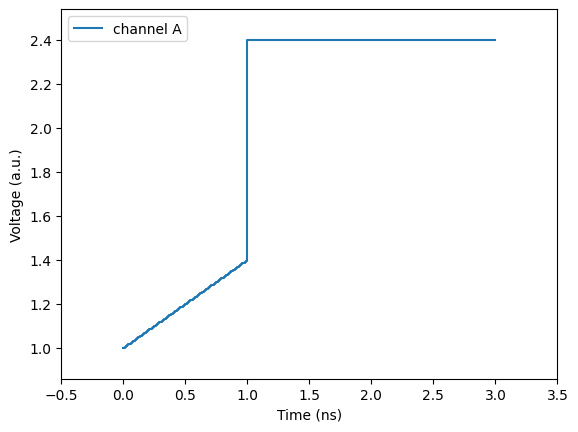

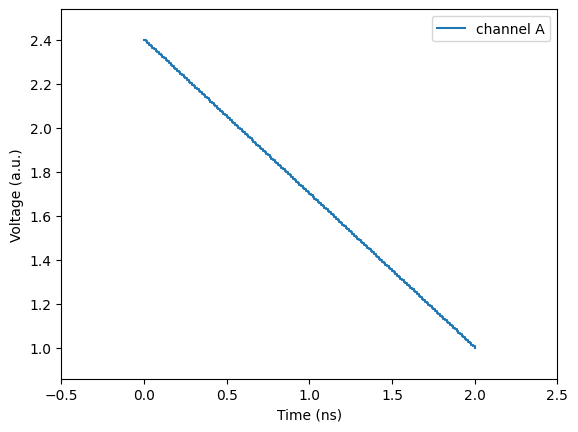

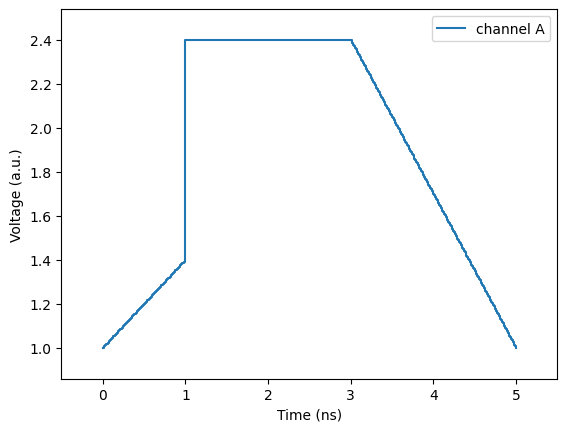

In [2]:
from qupulse.pulses.plotting import plot

parameters = dict(t=3,
                  t_2=2,
                  v_0=1,
                  v_1=1.4)

_ = plot(first_point_pt, parameters, sample_rate=100)
_ = plot(second_point_pt, parameters, sample_rate=100)
_ = plot(sequence_pt, parameters, sample_rate=100)


## RepetitionPulseTemplate: Repeating a Pulse

If we simply want to repeat some pulse template a fixed number of times, we can make use of the `RepetitionPulseTemplate`. In the following, we will reuse one of our `PointPT`s, `first_point_pt` and use it to create a new pulse template that repeats it `n_rep` times, where `n_rep` will be a parameter.

repetition parameters: {'t', 'v_0', 'v_1', 'n_rep'}
repetition measurements: {'M'}


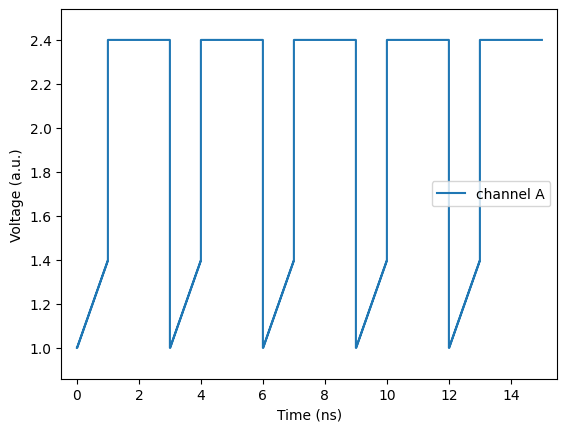

In [3]:
from qupulse.pulses import RepetitionPT

repetition_pt = RepetitionPT(first_point_pt, 'n_rep')

print("repetition parameters: {}".format(repetition_pt.parameter_names))
print("repetition measurements: {}".format(repetition_pt.measurement_names))

# let's plot to see the results
parameters['n_rep'] = 5 # add a value for our n_rep parameter
_ = plot(repetition_pt, parameters, sample_rate=100)

The same remarks that were made about `SequencePT` also hold for `RepetitionPT`: it will expose all parameters and measurements defined by its subtemplate and will be defined on the same channels.

## ForLoopPulseTemplate: Repeat a Pulse with a Varying Loop Parameter

The `RepetitionPT` simple repeats the exact same subtemplate a given number of times. Sometimes, however, it is rather required to vary the parameters of a subtemplate in a loop, for example when trying to determine the best value for a parameter of a given pulse. This is what the `ForLoopPulseTemplate` is intended for. As the name suggests, its behavior mimics that for `for-loop` constructs in programming languages by repeating its content - the subtemplate - for a number of times while at the same time supplying a loop parameter that iterates over a range of values.

In the following we make use of this to vary the value of parameter `t` in `first_point_pt` over several iterations. More specifically, we will have all a `first_point_pt` pulse for all even values of `t` between `t_start` and `t_end` which are new parameters. For the plot we will set them to `t_start = 4` and `t_end = 13`, i.e., `t = 4, 6, 8, 10, 12`.

for loop parameters: {'v_0', 'v_1', 't_end', 't_start'}
for loop measurements: {'M'}


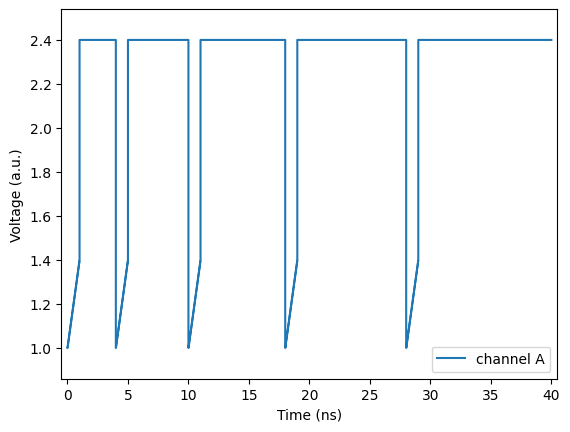

In [4]:
from qupulse.pulses import ForLoopPT

for_loop_pt = ForLoopPT(first_point_pt, 't', ('t_start', 't_end', 2))

print("for loop parameters: {}".format(for_loop_pt.parameter_names))
print("for loop measurements: {}".format(for_loop_pt.measurement_names))

# plot it
parameters['t_start'] = 4
parameters['t_end'] = 13
_ = plot(for_loop_pt, parameters, sample_rate=100)

The second argument to `ForLoopPT`'s constructor is the name of the loop parameter. This has to be a parameter that is defined by the subtemplate. The third argument defined the range of the loop. The syntax of the range is similar to that of the `range()` command in Python, i.e., a tuple `(start_value, end_value, step)`. As seen above, inserting parameter values or even expressions is okay. As in `range()`, the `end_value` is exclusive.

As for `SequencePT` and `RepetitionPT`, `ForLoopPT` exposes all parameters defined by the subtemplate except for the loop parameter, `t` in the above example. If expressions are used in the range definition and they make use of additional parameters, these are also exposed by `ForLoopPT`. 

`ForLoopPT` also exposes measurements defined by subtemplates.

## AtomicMultiChannelPulseTemplate: Run Pulses in Parallel on Different Channels

So far we have only looked at pulses that affect the time-domain aspect of combining pulses. Another way to combine pulses is to parallelise them by executing them on different channels at the same time. This is of course already supported by simply creating atomic pulse templates (`TablePT`, `PointPT`, `FunctionPT`) on multiple channels. However, sometimes it is necessary to put already existing pulses in parallel. Instead of having to define a new atomic pulse template for this, we can make use of the `AtomicMuliChannelPulseTemplate` class. To learn more about how this works, see [Multi-Channel Pulses](00MultiChannelTemplates.ipynb).

## Combining Combined Pulses

Our examples above have build combined higher-level pulses (`SequencePT`, `RepetitionPT`, `ForLoopPT`) on atomic subtemplates only. However, this is not a requirement. We can use `SequencePT`, `RepetitionPT` and `ForLoopPT` using any `PulseTemplate` objects as subtemplates allowing us to build arbitrarily complex pulses out of only a handful of primitives.